In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

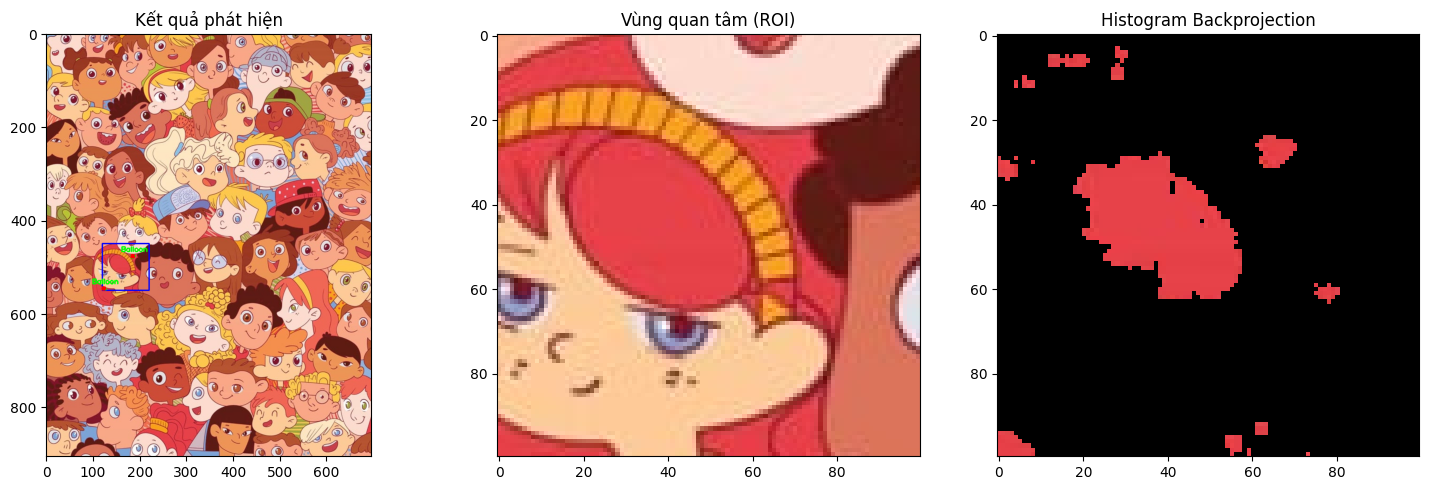

In [47]:
def detect_hidden_balloon(scene_path, template_path, roi_x, roi_y, roi_width, roi_height):
    # Đọc ảnh
    scene = cv2.imread(scene_path)
    template = cv2.imread(template_path)
    
    # Xác định ROI (Region of Interest) - vùng tóc đỏ
    roi = scene[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
    
    # Chuyển sang không gian màu HSV cho cả hai ảnh
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    template_hsv = cv2.cvtColor(template, cv2.COLOR_BGR2HSV)
    
    # Tính histogram của template
    template_hist = cv2.calcHist([template_hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(template_hist, template_hist, 0, 255, cv2.NORM_MINMAX)
    
    # Áp dụng backprojection để tìm kiếm trong ROI
    dst = cv2.calcBackProject([roi_hsv], [0, 1], template_hist, [0, 180, 0, 256], 1)
    
    # Áp dụng một số xử lý hình thái học để cải thiện kết quả
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cv2.filter2D(dst, -1, disc, dst)
    
    # Ngưỡng và nhị phân hóa
    ret, thresh = cv2.threshold(dst, 50, 255, 0)
    thresh = cv2.merge((thresh, thresh, thresh))
    
    # Kết quả backprojection
    result = cv2.bitwise_and(roi, thresh)
    
    # Tìm contours trong kết quả
    result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(result_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Lọc contours dựa trên kích thước và hình dạng
    balloon_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 20 and area < 500:  # Điều chỉnh ngưỡng kích thước phù hợp
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.3:  # Bóng bay thường có độ tròn cao
                    balloon_contours.append(contour)
    
    # Vẽ kết quả
    output = scene.copy()
    cv2.rectangle(output, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (255, 0, 0), 2)
    
    for contour in balloon_contours:
        # Điều chỉnh tọa độ contour về hệ tọa độ của ảnh gốc
        adjusted_contour = contour.copy()
        adjusted_contour[:, :, 0] += roi_x
        adjusted_contour[:, :, 1] += roi_y
        
        cv2.drawContours(output, [adjusted_contour], 0, (0, 255, 0), 2)
        
        # Vẽ điểm giữa
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"]) + roi_x
            cY = int(M["m01"] / M["m00"]) + roi_y
            cv2.circle(output, (cX, cY), 5, (0, 0, 255), -1)
            cv2.putText(output, "Balloon", (cX - 25, cY - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return output, roi, result

# Sử dụng hàm
# Các giá trị roi_x, roi_y, roi_width, roi_height cần điều chỉnh để khớp với vị trí của nhân vật tóc đỏ
output, roi, backprojection = detect_hidden_balloon(scene_path, template_path, 120, 450, 100, 100)

# Hiển thị kết quả
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Kết quả phát hiện')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title('Vùng quan tâm (ROI)')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(backprojection, cv2.COLOR_BGR2RGB))
plt.title('Histogram Backprojection')

plt.tight_layout()
plt.show()

In [67]:
def multiscale_template_matching(template_path, scene_path, scales=None, use_edges=True, 
                                 draw_box=True, confidence_threshold=0.2):
    # Đọc ảnh
    template = cv2.imread(template_path)
    scene = cv2.imread(scene_path)
    
    # Kiểm tra nếu ảnh không được nạp thành công
    if template is None or scene is None:
        print("Lỗi: Không thể đọc ảnh template hoặc scene")
        return None, []
    
    # Tạo bản sao của ảnh scene để vẽ kết quả
    output = scene.copy()
    template_display = template.copy()
    
    # Chuyển sang grayscale
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)
    
    # Nếu dùng edge detection
    if use_edges:
        # Áp dụng Canny edge detection
        template_gray = cv2.Canny(template_gray, 50, 200)
        scene_gray = cv2.Canny(scene_gray, 50, 200)
    
    # Lấy kích thước template gốc
    (tH, tW) = template_gray.shape[:2]
    
    # Khởi tạo danh sách kết quả và vị trí tốt nhất
    results = []
    best_match = None
    best_score = -np.inf
    
    # Nếu không cung cấp scales, dùng mặc định
    if scales is None:
        scales = np.linspace(0.2, 1.0, 20)[::-1]
    
    # Lặp qua mỗi scale
    for scale in scales:
        # Resize template theo scale
        width = int(tW * scale)
        height = int(tH * scale)
        
        # Đảm bảo kích thước tối thiểu
        if width < 8 or height < 8:
            continue
            
        resized_template = cv2.resize(template_gray, (width, height))
        
        # Áp dụng template matching
        result = cv2.matchTemplate(scene_gray, resized_template, cv2.TM_CCOEFF_NORMED)
        
        # Tìm vị trí và giá trị tốt nhất
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
        
        # Lưu kết quả
        results.append({
            "scale": scale,
            "maxVal": maxVal,
            "maxLoc": maxLoc,
            "width": width,
            "height": height
        })
        
        # Cập nhật vị trí tốt nhất nếu cần
        if maxVal > best_score:
            best_score = maxVal
            best_match = {
                "scale": scale,
                "maxVal": maxVal,
                "maxLoc": maxLoc,
                "width": width,
                "height": height
            }
    
    # Sắp xếp kết quả theo giá trị tốt nhất
    results = sorted(results, key=lambda x: x["maxVal"], reverse=True)
    
    if not draw_box:
        return output, results
    
    detected_locations = []
    
    # Vẽ top 3 kết quả tốt nhất nếu vượt qua ngưỡng
    for r in results[:5]:  # Tăng lên 5 kết quả tốt nhất để có nhiều lựa chọn hơn
        if r["maxVal"] >= confidence_threshold:
            # Lấy thông tin
            (maxLoc, scale, width, height, maxVal) = (r["maxLoc"], r["scale"], r["width"], r["height"], r["maxVal"])
            
            # Vẽ hình chữ nhật
            startX, startY = maxLoc
            endX, endY = startX + width, startY + height
            
            # Kiểm tra xem vị trí này đã được phát hiện chưa
            is_duplicate = False
            for (sx, sy, ex, ey) in detected_locations:
                # Tính IoU (Intersection over Union)
                x_overlap = max(0, min(endX, ex) - max(startX, sx))
                y_overlap = max(0, min(endY, ey) - max(startY, sy))
                overlap_area = x_overlap * y_overlap
                
                area1 = (endX - startX) * (endY - startY)
                area2 = (ex - sx) * (ey - sy)
                
                # Tính IoU
                iou = overlap_area / float(area1 + area2 - overlap_area)
                
                if iou > 0.3:  # Ngưỡng trùng lặp
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                # Vẽ bounding box với hiệu ứng đẹp hơn
                # 1. Vẽ viền ngoài đậm hơn
                cv2.rectangle(output, (startX, startY), (endX, endY), (0, 0, 0), 4)
                # 2. Vẽ viền trong màu sắc tùy theo điểm số
                # Màu thay đổi từ đỏ (thấp) -> vàng -> xanh lá (cao)
                confidence_color = (
                    0,                                # B
                    int(255 * maxVal),               # G
                    int(255 * (1 - maxVal)) if maxVal > 0.7 else 255  # R
                )
                cv2.rectangle(output, (startX, startY), (endX, endY), confidence_color, 2)
                
                # Vẽ thanh chỉ thị điểm số
                bar_width = 50
                bar_height = 5
                bar_x = startX
                bar_y = startY - 20
                # Nền đen cho thanh
                cv2.rectangle(output, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), (0, 0, 0), -1)
                # Phần được lấp đầy dựa trên điểm số
                filled_width = int(bar_width * maxVal)
                cv2.rectangle(output, (bar_x, bar_y), (bar_x + filled_width, bar_y + bar_height), confidence_color, -1)
                
                # Hiển thị thông tin
                info_text = f"Score: {maxVal:.2f}, Scale: {scale:.2f}"
                text_y = startY - 25
                # Tạo nền đen cho văn bản
                (text_w, text_h), _ = cv2.getTextSize(info_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(output, (startX, text_y - text_h - 2), (startX + text_w, text_y + 2), (0, 0, 0), -1)
                # Vẽ văn bản
                cv2.putText(output, info_text, (startX, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                
                # Vẽ các điểm góc để làm nổi bật bounding box
                corner_length = 10
                # Top-left
                cv2.line(output, (startX, startY), (startX + corner_length, startY), (255, 255, 255), 2)
                cv2.line(output, (startX, startY), (startX, startY + corner_length), (255, 255, 255), 2)
                # Top-right
                cv2.line(output, (endX, startY), (endX - corner_length, startY), (255, 255, 255), 2)
                cv2.line(output, (endX, startY), (endX, startY + corner_length), (255, 255, 255), 2)
                # Bottom-left
                cv2.line(output, (startX, endY), (startX + corner_length, endY), (255, 255, 255), 2)
                cv2.line(output, (startX, endY), (startX, endY - corner_length), (255, 255, 255), 2)
                # Bottom-right
                cv2.line(output, (endX, endY), (endX - corner_length, endY), (255, 255, 255), 2)
                cv2.line(output, (endX, endY), (endX, endY - corner_length), (255, 255, 255), 2)
                
                detected_locations.append((startX, startY, endX, endY))
    
    # Hiển thị template gốc ở góc phải trên của ảnh
    if template_display is not None:
        # Resize template để hiển thị nhỏ hơn
        display_width = min(150, scene.shape[1] // 5)
        display_ratio = display_width / template.shape[1]
        display_height = int(template.shape[0] * display_ratio)
        template_small = cv2.resize(template_display, (display_width, display_height))
        
        # Vị trí để chèn template
        x_offset = scene.shape[1] - display_width - 10
        y_offset = 10
        
        # Tạo nền và viền cho template hiển thị
        cv2.rectangle(output, (x_offset-2, y_offset-2), 
                     (x_offset+display_width+2, y_offset+display_height+2), (0, 0, 0), 2)
        
        # Chèn template vào ảnh
        output[y_offset:y_offset+display_height, x_offset:x_offset+display_width] = template_small
        
        # Thêm text "Template"
        cv2.putText(output, "Template", (x_offset, y_offset - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(output, "Template", (x_offset, y_offset - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return output, results

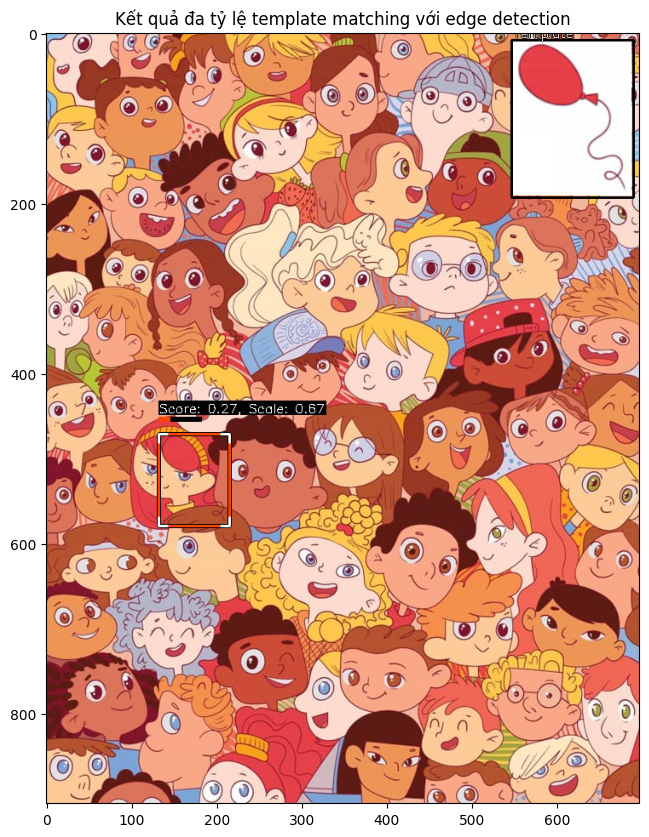

Top 5 kết quả tốt nhất:
#1: Scale=0.67, Score=0.2681, Location=(132, 471)
#2: Scale=0.66, Score=0.2530, Location=(132, 471)
#3: Scale=0.67, Score=0.2447, Location=(132, 471)
#4: Scale=0.66, Score=0.2361, Location=(133, 472)
#5: Scale=0.68, Score=0.2248, Location=(132, 471)


In [68]:
# Sử dụng hàm
scales = np.linspace(0.5, 1, 100)  # Có thể thử với nhiều range scales khác nhau
output, results = multiscale_template_matching(template_path, scene_path, scales=scales, use_edges=True)

# Hiển thị kết quả
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Kết quả đa tỷ lệ template matching với edge detection')
plt.show()

# In các kết quả tốt nhất
print("Top 5 kết quả tốt nhất:")
for i, r in enumerate(results[:5]):
    print(f"#{i+1}: Scale={r['scale']:.2f}, Score={r['maxVal']:.4f}, Location={r['maxLoc']}")